# Machine Learning em Marketing Digital: Prevendo a Probabilidade de Conversão do Lead

**Problema de Negócio:**

Seu chefe convida você para uma reunião e informa que a área de Marketing Digital ficou muito satisfeita com seu projeto de previsão do número de usuários convertidos. Mas agora, eles desejam um modelo que entregue uma previsão um pouco diferente

Considerando detalhes de uma nova campanha de Marketing, eles desejam saber se um lead vai ou não ser convertido (ou seja, se um potencial cliente vai ou não se tornar cliente e comprar o produto). Além disso, eles desejam saber a probabilidade. Eles precisam responder esta  pergunta  de  negócio:  Se  a  previsão  do  modelo  é  que  um  lead  será  convertido,  qual  a probabilidade de issoacontecer?

1. Qual o número provável de usuários convertidos? (Regressão)
2. Um lead será convertido? Sim ou não? Qual a probabilidade? (Classificação)

In [14]:
# Ajustar as casas decimais
options(scipen = 999, digits = 4)

# Definir um espelho de CRAN
options(repos = "http://cran.rstudio.com/")

In [ ]:
# Lista dos pacotes necessários
library('dplyr')

pacotes <- c('tidyverse', 'ggplot2', 'corrplot', 'plotly', 'plyr', 'skimr')

pacotes %>%
  lapply(function(pacote){
    if (!require(pacote, character.only = TRUE)) {
      install.packages(pacote)
      library(pacote, character.only = TRUE)
    }
  })

In [1]:
# Importando o dataset preparado para o modelo de ML
df <- read.csv('/content/dataset.csv')

In [5]:
# Visualizando as 10 primeiras linhas
head(df)

,valor_gasto_campanha,numero_visualizacoes,numero_cliques,usuarios_convertidos
,<int>,<int>,<int>,<int>
1,875,4390,54,30
2,1451,7120,90,72
3,1232,6198,67,47
4,1099,5554,70,63
5,656,3336,41,34
6,656,3388,34,18


In [15]:
# Visualizando os tipos de dados
str(df)

'data.frame':	500 obs. of  4 variables:
 $ valor_gasto_campanha: int  875 1451 1232 1099 656 656 558 1366 1101 1208 ...
 $ numero_visualizacoes: int  4390 7120 6198 5554 3336 3388 2874 6877 5499 5874 ...
 $ numero_cliques      : int  54 90 67 70 41 34 31 79 71 86 ...
 $ usuarios_convertidos: int  30 72 47 63 34 18 25 61 58 74 ...


Cada observação representa uma campanha no histórico da empresa.


*   **valor_gasto_campanha:** Valor investido R$
*   **numero_visualizacoes:** Total de visitas no site
*   **numero_cliques:** Total de cliques na campanha, suposto "interesse no produto"
*   **usuarios_convertidos:** Usuários que se identificaram com a campanha e viraram clientes. Agora está na base de dados da empresa.





In [16]:
# Analisando as estatísticas básica
summary(df)

 valor_gasto_campanha numero_visualizacoes numero_cliques  usuarios_convertidos
 Min.   : 505         Min.   :2376         Min.   :  9.0   Min.   :  4.0       
 1st Qu.: 742         1st Qu.:3710         1st Qu.: 47.0   1st Qu.: 36.0       
 Median :1013         Median :5112         Median : 65.0   Median : 49.0       
 Mean   : 999         Mean   :5005         Mean   : 64.6   Mean   : 49.6       
 3rd Qu.:1256         3rd Qu.:6280         3rd Qu.: 81.2   3rd Qu.: 63.0       
 Max.   :1493         Max.   :7528         Max.   :116.0   Max.   :101.0       

Primeira análise é identificar os valores de mediana e média (valores próximos, supostamente o conjunto de dados segue uma distribuição normal)

In [18]:
# Analisando a correlação entre as variáveis
cor_matrix <- cor(df)
cor_matrix

,valor_gasto_campanha,numero_visualizacoes,numero_cliques,usuarios_convertidos
valor_gasto_campanha,1.0000,0.9978,0.9376,0.8502
numero_visualizacoes,0.9978,1.0000,0.9366,0.8482
numero_cliques,0.9376,0.9366,1.0000,0.9266
usuarios_convertidos,0.8502,0.8482,0.9266,1.0000


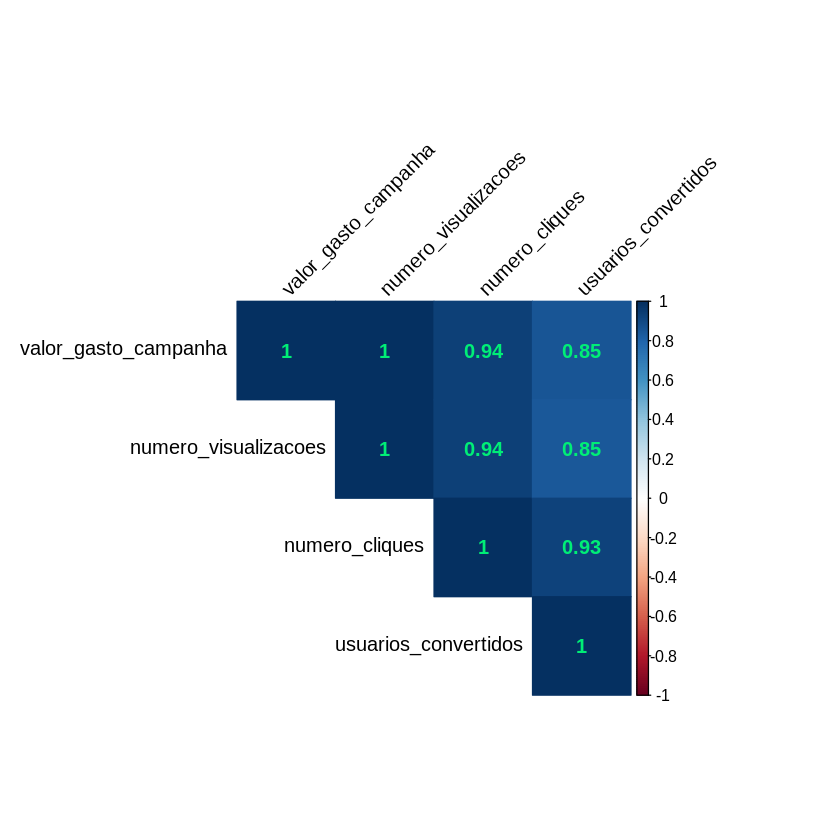

In [20]:
# Visualizando graficamente a correlação entre as variáveis
corrplot(cor_matrix,
  method = 'color',
  type = 'upper', # mostrar apenas a parte superior, simétrica
  addCoef.col = 'springgreen2', # coeficiente corr
  tl.col = 'black',
  tl.srt = 45
)


Forte correlação das variáveis, ou seja, se uma variável aumenta, a tendência da outra é aumentar também!


*   **valor_gasto_campanha vs usuarios_convertidos:** Forte correlação positiva, ou seja, aumenta o valor gasto na campanha, tende a converter mais usuários (alcance maior da campanha);
*   **numero_visualizações vs usuarios_convertidos:** Aumenta o número de visualizações na página, produto, consequentemente irá vender mais;
*   **numero_cliques vs usuarios_convertidos:** Maior número de cliques, maior o número de usuários convertidos.

1. Entre a variável alvo (usuarios_convertidos) e entre as variáveis preditoras, queremos a maior correlação possível?

2. Entre a variáveis preditores, queremos a menor correlação possível?

A matriz apresenta uma alta multicolinearidade entre as variáveis preditoras, que é quando a correlação é alta entre eles, inclusive consta um valor 1 (valor_gasto_campanha vs numero_visualizações)


## Analisando as variáveis preditoras vs Variável Alvo

Analisando graficamente as varíaveis devido apresentarem multicolinearidade na matriz de Correlação.

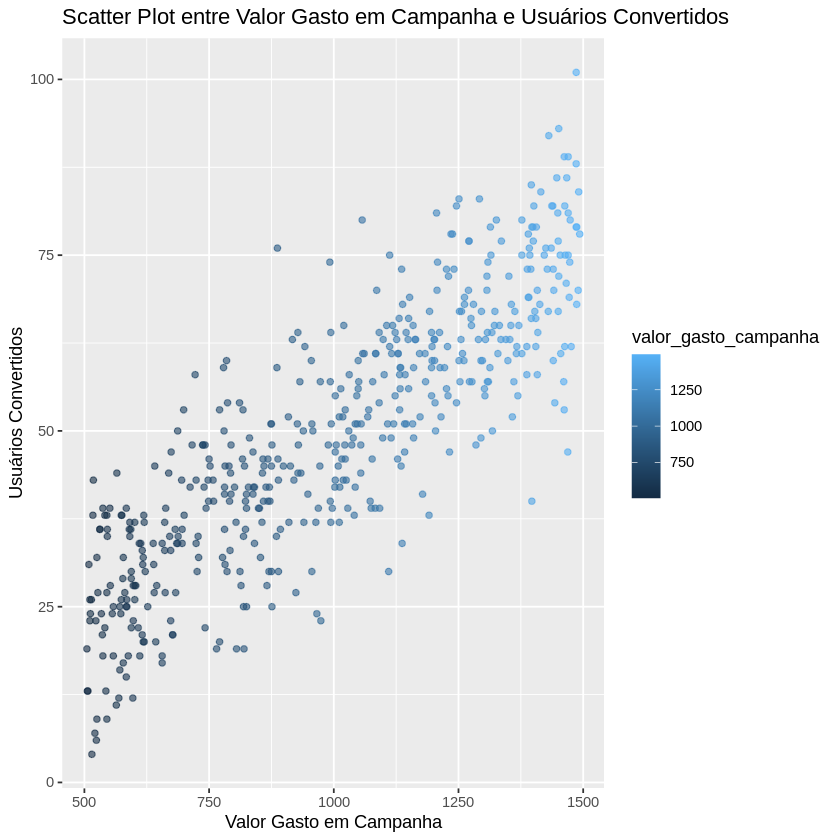

In [22]:
# Valor gasto vs Usuários Convertidos
ggplot(df,
aes(x=valor_gasto_campanha,y=usuarios_convertidos)) +
geom_point(aes(color=valor_gasto_campanha), alpha=0.6) +
ggtitle('Scatter Plot entre Valor Gasto em Campanha e Usuários Convertidos') +
xlab('Valor Gasto em Campanha') +
  ylab('Usuários Convertidos')

Confirmamos que à medida que o valor gasto em campanha aumenta, o número de usuários convertidos aumenta, também!

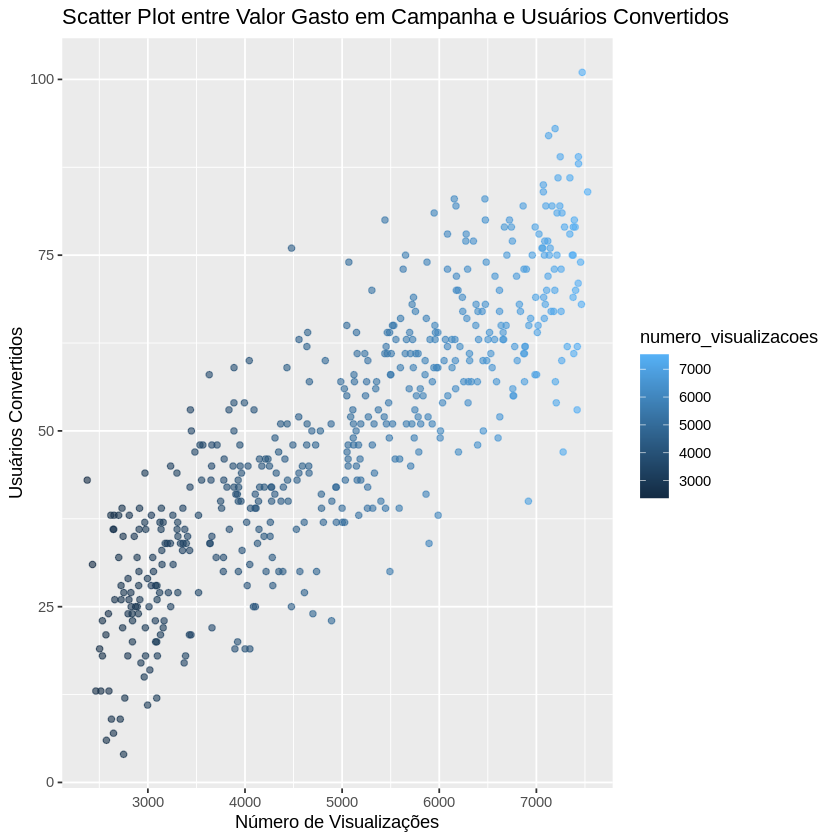

In [23]:
# Número de Visualizações vs Usuários Convertidos
ggplot(df,
aes(x=numero_visualizacoes,y=usuarios_convertidos)) +
geom_point(aes(color=numero_visualizacoes), alpha=0.6) +
ggtitle('Scatter Plot entre Valor Gasto em Campanha e Usuários Convertidos') +
xlab('Número de Visualizações') +
  ylab('Usuários Convertidos')

Confirmado também a forte correlação positiva, à medida que o número de visualizações crescem, consequentemente o número de usuários convertidos também aumenta!

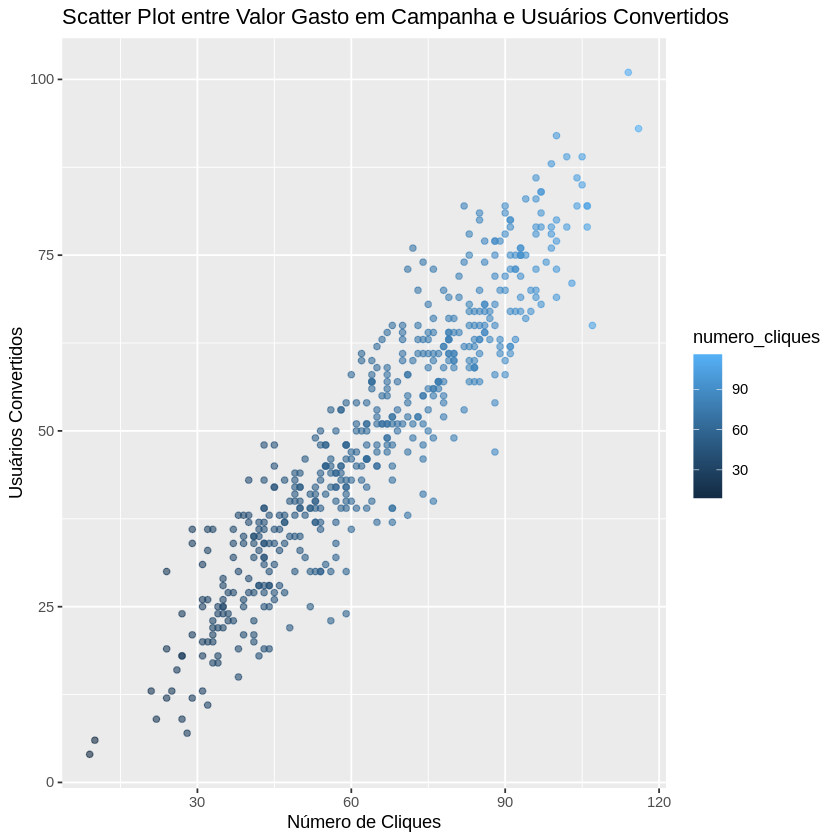

In [27]:
# Número de Cliques vs Usuários Convertidos
ggplot(df,
aes(x=numero_cliques,y=usuarios_convertidos)) +
geom_point(aes(color=numero_cliques), alpha=0.6) +
ggtitle('Scatter Plot entre Valor Gasto em Campanha e Usuários Convertidos') +
xlab('Número de Cliques') +
  ylab('Usuários Convertidos')

Confirmado também a forte correlação positiva, à medida que o número de cliques crescem, consequentemente o número de usuários convertidos também aumenta!

Concluímos que os dados de fato apresentam uma regularidade no quesito de correlação, através da análise gráfica entre as variáveis preditoras e a alvo, nota-se esse comportamento e garante que podemos prosseguir com o dataset para as próximas etapas do modelo de Machine Learning.


# Criando os modelos de ML

## Regressão Linear Múltipla
Como o nosso dataset apresenta mais de uma variável preditora, utilizaremos a "Regressão Linear Múltipla".

In [26]:
# Criando o modelo de ML RLM
# Alvo: usuarios_convertidos
# Preditoras: . (todas as demais variáveis)
modelo_v1 <- lm(usuarios_convertidos ~ ., data = df)
summary(modelo_v1)


Call:
lm(formula = usuarios_convertidos ~ ., data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-21.187  -4.104  -0.114   4.166  18.420 

Coefficients:
                     Estimate Std. Error t value            Pr(>|t|)    
(Intercept)          -1.56346    1.08164   -1.45                0.15    
valor_gasto_campanha  0.00780    0.01575    0.49                0.62    
numero_visualizacoes -0.00351    0.00314   -1.12                0.26    
numero_cliques        0.94388    0.04228   22.33 <0.0000000000000002 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 6.86 on 496 degrees of freedom
Multiple R-squared:  0.862,	Adjusted R-squared:  0.861 
F-statistic: 1.03e+03 on 3 and 496 DF,  p-value: <0.0000000000000002


### Interpretação do modelo:

Fómula de Regressão:
y = a + bx
y = a + b1x1 + b2x2 + b3x3

Como se fosse:
y = intercept + valor_gasto_campanha.x1 + numero_visualizacoes.x2 + numero_cliques.x3

1. **Residuals:** São as diferenças entre os valores observados e os valores previstos pelo modelo. Os quartis dos resíduos(Min, 1Q, Media, 3Q, Max) apresentam uma ideia de distribuição dos erros. Em geral, seria ideal que esses valores fossem distribuídos simetricamente em torno de zero, o que indica que o modelo realiza um bom trabalho na previsão;

2. **Coefficients:**
  *   **Intercept:** Valor da variável dependente (usuários convertidos) quando todas as variáveis independentes são zero, este valor é -1.45. Mas o valor-p associado é maior que 0,05 o que indica que o intercepto não é significadamente diferente de zero neste modelo;
  *   **valor_gasto_campanha:** O coeficiente é 0.00780, mas o valor-p associado é 0.62 > 0.05, o que indica que essa variável não é estatisticamente significante na previsão de usuários convertidos, pelo menos neste modelo;
  *   **numero_visualizacoes:** O coeficiente é -0.00351, e o valor-p é 0.26 > 0.05, também sugere que a variável não é significativa;
  *   **numero_cliques:** O coeficiente é 0.94, com um valor-p de extremamente baixo (<2e-16). Isso indica que essa variável é altamente significativa na previsão de usuários convertidos;

3. **Residual Standard error:** É uma medida de qualidade do modelo, quanto menos, melhor o modelo. Neste caso é 6.865.

4. **Multiple R-squared e Adjusted R-squared:** Indicadores da qualidade do modelo em termos de sua capacidade de prever a variável dependente. Um valor mais próximo de 1 é gerealmente melhor. Neste caso, eles são relativamente altos (0.8617 e 0.8609, respectivamente), o que é positivo(86.2% da variabilidade na variável usuarios_convertidos é explicada pelas variáveis preditoras do modelo).

  - R² < 0.3: Baixo ajuste.
  - 0.3 ≤ R² < 0.6: Ajuste moderado.
  - 0.6 ≤ R² < 0.8: Bom ajuste.
  - R² ≥ 0.8: Alto ajuste.

5. **F-statistic e p-value:** Um teste F é realizado para determinar se o modelo como um todo é significativo. O valor de F é 1030 e o valor-p associado é muito baixo (< 2e-16), indicando que o modelo é significativo.

### Conclusão
O modelo parece fazer um bom trabalho na previsão de "usuários convertidos" (R-Squared alto), mas apenas a variável "número de cliques" é estatisticamente significativa na previsão. Isso pode implicar que o "número de cliques" é a principal variável que você deve se concentrar para enternder as conversões de usuários.

As outras variáveis(valor gasto em campanhas e número de visualizações) não são significativas neste modelo, o que sugere que elas podem não ser úteis para prever a variável dependente, ou que outros fatores podem estar em jogo, como multicolinearidade.

Lembrando, na análise exploratória, identificamos multicolinearidade entre as variáveis preditoras e não solucionamos. Portanto, o modelo aprendeu junto com este "problema". Portanto como solução, será realizado uma nova versão do modelo, selecionando apenas a variável preditora significativa (numero_cliques) e tiraremos as conclusões. Excluindo as demais variáveis, estaríamos eliminando o problema da multicolinearidade.
****

## Regressão Linear Simples
Agora treinaremos o modelo somente com a variável preditora (numero de cliques) em relação à variável alvo (usuários convertidos)

In [28]:
# Projetando a nova versão do modelo de regressão, neste caso, simples.
modelo_v2 <- lm(usuarios_convertidos ~ numero_cliques, data=df)
summary(modelo_v2)


Call:
lm(formula = usuarios_convertidos ~ numero_cliques, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-21.721  -4.107  -0.199   4.242  20.318 

Coefficients:
               Estimate Std. Error t value            Pr(>|t|)    
(Intercept)     -2.9903     1.0061   -2.97              0.0031 ** 
numero_cliques   0.8149     0.0148   54.97 <0.0000000000000002 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 6.93 on 498 degrees of freedom
Multiple R-squared:  0.859,	Adjusted R-squared:  0.858 
F-statistic: 3.02e+03 on 1 and 498 DF,  p-value: <0.0000000000000002


O modelo de fato apresenta o mesmo R-squared, no entanto, está simples demais, ao relacionar com o problema de negócio e o cenário, não faz muito sentido analisar apenas a campanha pelo número de cliques. Portanto, estaremos incrementando novas variáveis para tornar o modelo ainda mais eficiente e resolver o problema da Multicolinearidade dos dados.
****
## Engenharia de Atributos antes da RLM

In [29]:
# Criação da nova variável preditora (taxa_de_clique)
df$taxa_de_clique <- df$numero_cliques / df$numero_visualizacoes
head(df)

,valor_gasto_campanha,numero_visualizacoes,numero_cliques,usuarios_convertidos,taxa_de_clique
,<int>,<int>,<int>,<int>,<dbl>
1,875,4390,54,30,0.01230
2,1451,7120,90,72,0.01264
3,1232,6198,67,47,0.01081
4,1099,5554,70,63,0.01260
5,656,3336,41,34,0.01229
6,656,3388,34,18,0.01004


In [32]:
# Verificar se consta algum valor igual a zero
any(df$taxa_de_clique == 0)

[1] FALSE

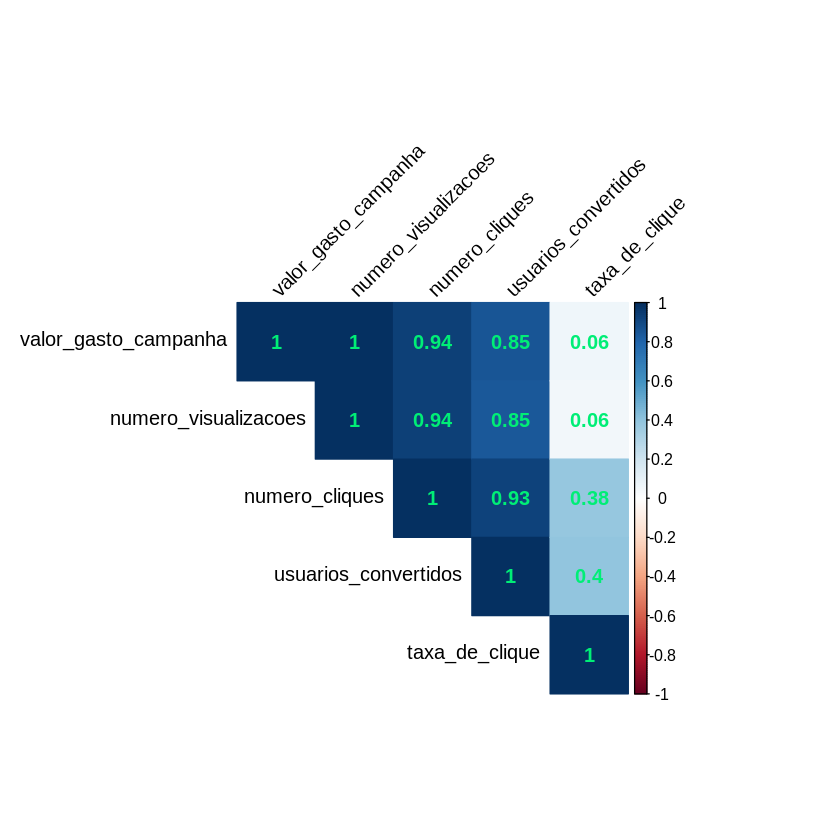

In [34]:
# Visualizando graficamente a correlação entre as variáveis
corrplot(cor(df),
  method = 'color',
  type = 'upper', # mostrar apenas a parte superior, simétrica
  addCoef.col = 'springgreen2', # coeficiente corr
  tl.col = 'black',
  tl.srt = 45
)

Espera-se que a correlação entre as variáveis preditoras seja a menos possível, neste caso analisando a nova variável "taxa_de_clique" em relação as demais, nota-se que está em torno de 0.06, o que é um ponto positivo.

Em relação à variável alvo, a correlação é de 0.38, não é uma forte correlação, mas é aceitável, não está tão baixa próximo de zero e nem tão alta.
****
## Regressão Linear Múltipla
Agora treinaremos o modelo com as variáveis preditoras (numero de cliques e taxa_de_cliques) em relação à variável alvo (usuários convertidos)


In [36]:
# Projetando a nova versão do modelo de regressão, neste caso, simples.
modelo_v3 <- lm(usuarios_convertidos ~ valor_gasto_campanha + taxa_de_clique, data = df)
summary(modelo_v3)


Call:
lm(formula = usuarios_convertidos ~ valor_gasto_campanha + taxa_de_clique, 
    data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-23.829  -4.507  -0.169   4.281  20.744 

Coefficients:
                      Estimate Std. Error t value            Pr(>|t|)    
(Intercept)           -47.8521     2.6014   -18.4 <0.0000000000000002 ***
valor_gasto_campanha    0.0510     0.0011    46.3 <0.0000000000000002 ***
taxa_de_clique       3612.5871   186.8107    19.3 <0.0000000000000002 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 7.34 on 497 degrees of freedom
Multiple R-squared:  0.842,	Adjusted R-squared:  0.841 
F-statistic: 1.32e+03 on 2 and 497 DF,  p-value: <0.0000000000000002


Como utilizamos a variável "número de cliques" para criar uma nova "taxa de cliques" na junção de "número de cliques/numero de visualizações", não utilizaremos ela neste modelo, pois já está de certa forma acoplada na nova variável. Portanto, como observamos na matriz de correlação, não há multicolinearidade entre a variável "taxa_de_cliques vs valor_gasto_campanha", logo podemos utilizá-la para testar o novo modelo v3.

**Considerações Finais:**

- O modelo explica aproximadamente 84,20% da variação em usuarios_convertidos;
- O coeficiente para valor_gasto_campanha é 0.0510, isso significa que se manter todos as outras variáveis constantes, há um aumento de 1 unidade em valor_gasto_campanha e 0.0510 unidade em usuarios_convertidos;
- O coeficiente para taxa_de_clique é de 3612, isso significa que se manter todas as outras variáveis constantes, há um aumento de 1 unidade em taxa_de_cliques e 3612 unidades em usuarios_convertidos;
- Todos os preditores são significativos, com valores extremamente baixos (2e-16);
- O modelo é estatisticamente significativo, conforme o valor de p-value (2e-16) próximo a zero.


### Analisar o modelo V3

In [37]:
# Gerando os resíduos do modelo (erros da previsão)
residuos <- resid(modelo_v3)

`geom_smooth()` using formula = 'y ~ x'


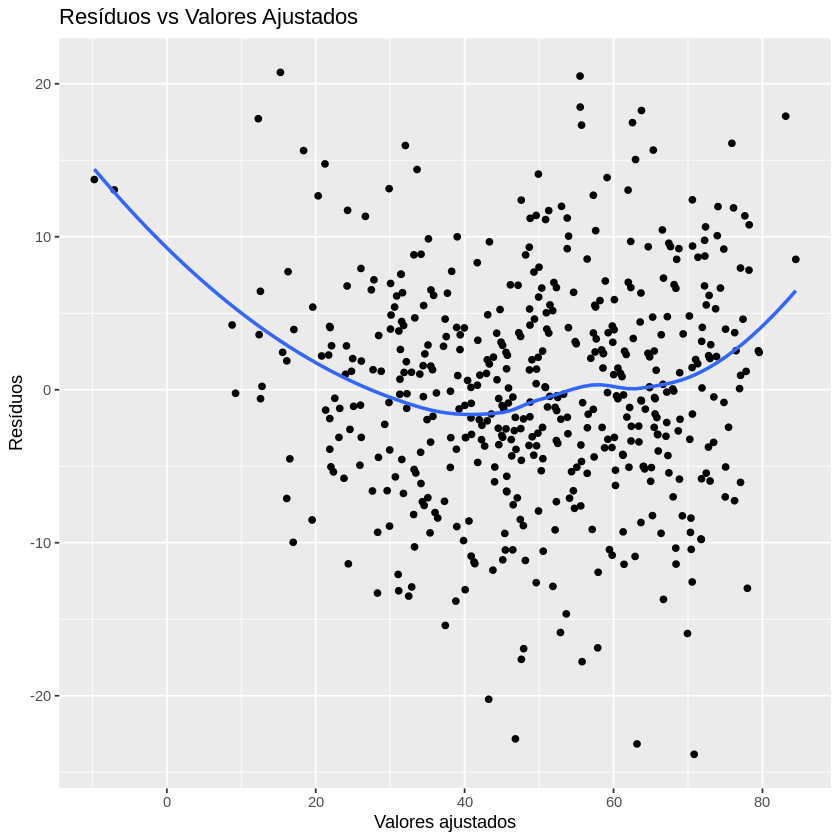

In [38]:
# Gráfico de Resíduos vS Valores Ajustados
ggplot(df,
aes(x=predict(modelo_v3),y=residuos)) +
geom_point() +
geom_smooth(se = FALSE, method = 'loess') +
ggtitle('Resíduos vs Valores Ajustados') +
xlab('Valores ajustados') +
ylab('Resíduos')

O gráfico de resíduos vs valores ajustados mostra como os resíduos (erros de previsão) do modelo de regressão linear múltipla estão distribuídos em relação aos valores ajustados (valores previstos pelo modelo).

- **Eixo X:** Valores ajustados (previsões do modelo)
- **Eixo Y:** Resíduos (erros de previsão)

**Interpretação:**

- **Pontos azuis:** Representam os resíduos individuais para cada observação.
- **Linha vermelha:** Representa a tendência geral dos resíduos.

**Observações:**

- Os resíduos estão distribuídos aleatoriamente em torno da linha zero, o que indica que o modelo está fazendo um bom trabalho na previsão dos valores de usuários convertidos.
- Não há padrões óbvios nos resíduos, o que sugere que o modelo não está sofrendo de problemas como heterocedasticidade ou autocorrelação.
- A linha vermelha é aproximadamente horizontal, o que indica que o modelo não está subestimando ou superestimando os valores de usuários convertidos em nenhuma faixa específica dos valores ajustados.

**Conclusão:**

O gráfico de resíduos versus valores ajustados não mostra nenhuma evidência de problemas significativos com o modelo de regressão linear múltipla.

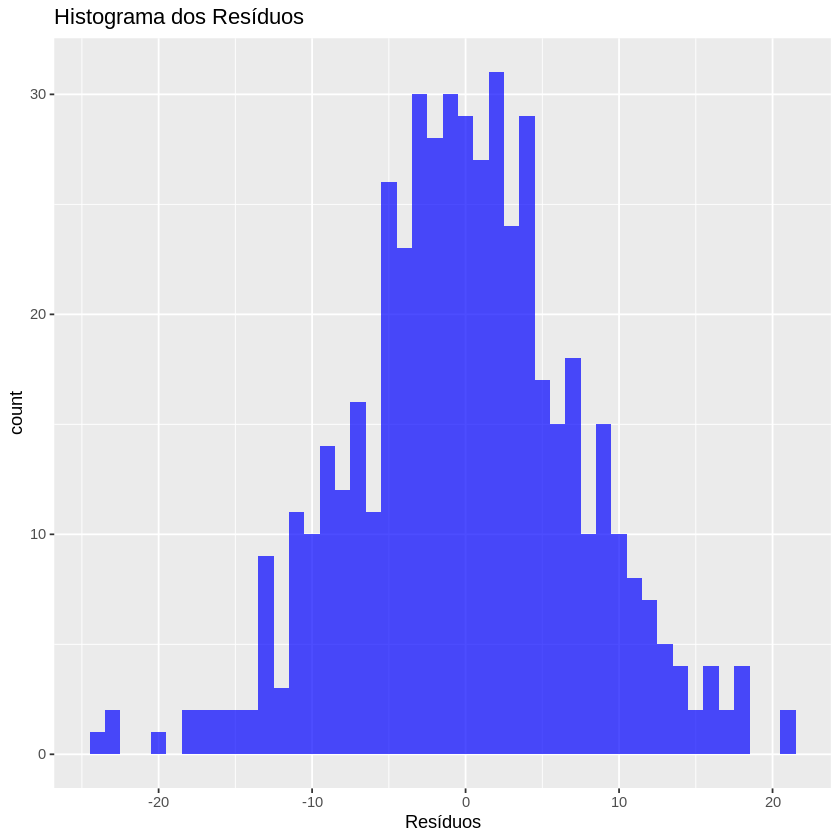

In [39]:
# Histograma dos Resíduos
ggplot(df,
aes(x=residuos)) +
geom_histogram(binwidth = 1, fill = 'blue', alpha = 0.7) +
ggtitle('Histograma dos Resíduos') +
xlab('Resíduos')


O histograma dos resíduos mostra a distribuição dos erros de previsão do modelo de regressão linear múltipla.

- **Eixo X:** Resíduos (erros de previsão)
- **Eixo Y:** Frequência (número de observações)

**Interpretação:**

- A maioria dos resíduos está concentrada em torno de zero, o que indica que o modelo está fazendo um bom trabalho na previsão dos valores de usuários convertidos.
- A distribuição dos resíduos é aproximadamente simétrica, o que sugere que não há tendência para subestimar ou superestimar os valores de usuários convertidos.
- As barras do histograma são relativamente estreitas, o que indica que os erros de previsão são geralmente pequenos.

**Conclusão:**

O histograma dos resíduos não mostra nenhuma evidência de problemas significativos com o modelo de regressão linear múltipla.

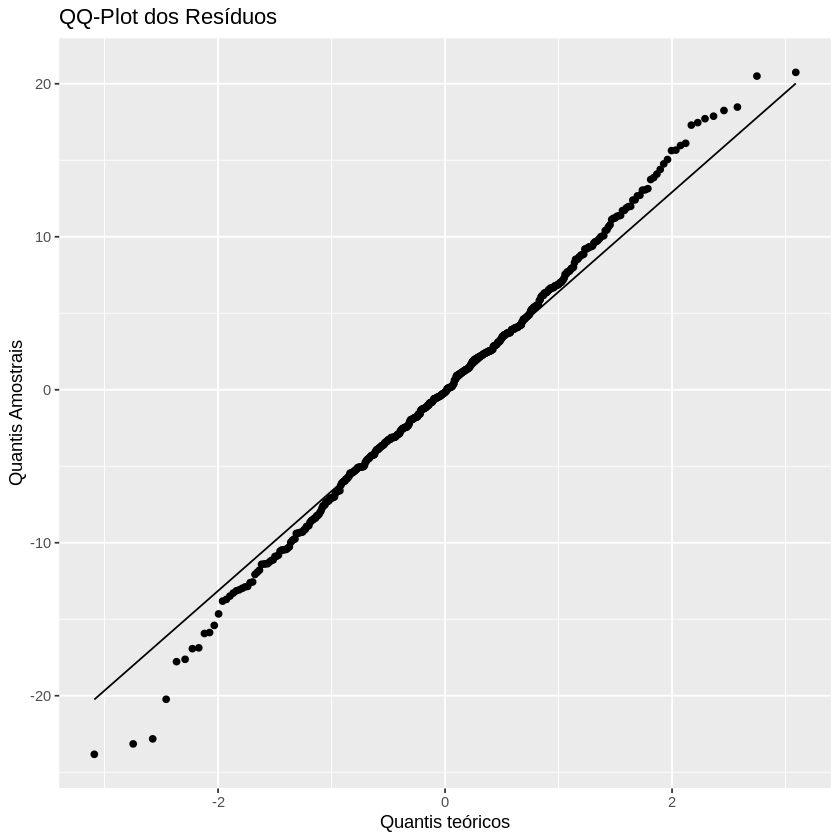

In [44]:
# QQ-Plot
ggplot(df, aes(sample = residuos)) +
geom_qq() +
geom_qq_line() +
ggtitle('QQ-Plot dos Resíduos') +
xlab('Quantis teóricos') +
ylab('Quantis Amostrais')

O gráfico QQ-plot compara os quantis teóricos de uma distribuição normal com os
quantis amostrais dos resíduos do modelo de regressão. Se os pontos estiverem
próximos à linha reta, isso indica que os resíduos estão normalmente distribuídos,
o que é um bom sinal para o modelo de regressão.

Neste caso, os pontos estão próximos à linha reta, o que sugere que os resíduos
do modelo de regressão estão normalmente distribuídos. Isso é um bom sinal para o
modelo de regressão, pois indica que o modelo é adequado para os dados.

In [45]:
# Salvando o modelo final
save(modelo_v3, file = 'modelo_v3.RData')

# Deploy do Modelo de ML
Colocar em produção o modelo_v3

In [46]:
# Carrega o modelo em disco
load('modelo_v3.RData')

In [ ]:
# Novos dados:
valor_gasto_campanha <- 1350 #Investido
numero_visualizacoes <- 7300 #Espera-se
numero_cliques <- 100 #Espera-se

In [52]:
# Criar novos dados para previsão
novos_dados <- data.frame(
  valor_gasto_campanha = c(1350),
  numero_visualizacoes = c(7300),
  numero_cliques = c(100)
)

In [53]:
# Reaplicar engenharia de atributo
novos_dados$taxa_de_clique <-
  novos_dados$numero_cliques / novos_dados$numero_visualizacoes

# Remove as variáveis que não serão usadas
novos_dados$numero_visualizacoes <- NULL
novos_dados$numero_cliques <- NULL

# Visualizar
head(novos_dados)

,valor_gasto_campanha,taxa_de_clique
,<dbl>,<dbl>
1,1350,0.0137


In [55]:
# Fazer previsões
previsoes <- predict(modelo_v3, newdata = novos_dados)

# Exibir previsões

cat('Esperamos este número de usuários convertidos:', as.integer(previsoes))

Esperamos este número de usuários convertidos: 70

### Fim!